 # Competición titanic con keras


 ## importar librerias y datos

In [1]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

 ## Unir los dataframes.

In [2]:
data = pd.concat([train_data, test_data])

 ## Ingeniera de datos

In [3]:
y_train = data[:891].Survived

# Borrar columnas innesesarias.
features_to_remove = ['PassengerId', 'Ticket', 'Cabin',  'Survived', 'Fare', ]
data = data.drop(features_to_remove , axis=1)
#  Reemplazar datos categóricos por de sexo 0s y  por 1s.
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])

Verificamos si hay valores nulos.

In [4]:
data.isna().sum()

Pclass        0
Name          0
Sex           0
Age         263
SibSp         0
Parch         0
Embarked      2
dtype: int64

 ### Generación de nuevos atributos

 A partir de ``SibSp`` y ``Parch`` generamos y reemplazamos lo anterior con un nuevo atributo para verificar si el pasajero arrivó solo o con algún pariente: ``IsAlone``.

In [5]:
data['IsAlone'] = 0
data.loc[ (data['SibSp'] + data['Parch']) == 0, 'IsAlone'] = 1 
data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

 A partir de Los prefijos de los nombres del los pasajeros, se genera un nuevo atributo que representa el prefijo de los nombres: ``Title``.


In [6]:
# Extraer prefijo del nombre de las personas.
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# Reemplazar los titulos raros con uno mas abarcativo: 'Rare'.
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace(['Mlle','Ms'], 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'] = LabelEncoder().fit_transform(data['Title'])
data.drop(['Name'], axis=1, inplace=True)


 Rellenamos ``Age`` faltantes según la relación con ``Sex`` y ``Pclass``.

In [7]:
guess_ages = np.zeros((2,3))

for i in range(0, 2): # itera con => 0,1 para sexo
    for j in range(0, 3):  # itera con => 1,2,3 para pclass
        guess_df = data[(data['Sex'] == i) & (data['Pclass'] == j+1)]['Age'].dropna()

        # Convierte el numero decimal al .5 mas cercano
        guess_ages[i,j] = round( guess_df.mean() *2 ) / 2

        data.loc[ (data.Age.isnull()) & (data.Sex == i) & (data.Pclass == j+1),'Age'] = guess_ages[i,j]

data["AgeCat"]= pd.cut(data["Age"], bins=[0, 15, 30, 45, 60, max(data["Age"]+1)], labels=[1, 2, 3, 4, 5])
data.drop(['Age'], axis=1, inplace=True)


 rellamos ``Embarked`` con el valor mas comun

In [8]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

 Convertimos columna de datos categóricos a variables dummys.

In [9]:
data = pd.get_dummies(data, columns=['Pclass', 'Embarked', 'Title'], prefix=['Pclass','Embarked', 'Title'])#, drop_first=True)

 Split y visualización de ``data``.

In [10]:
X_train = data[:891]
test = data[891:]

In [11]:
X_train

,Sex,IsAlone,AgeCat,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_0,Title_1,Title_2,Title_3,Title_4
0,1,0,2,0,0,1,0,0,1,0,0,1,0,0
1,0,0,3,1,0,0,1,0,0,0,0,0,1,0
2,0,1,2,0,0,1,0,0,1,0,1,0,0,0
3,0,0,3,1,0,0,0,0,1,0,0,0,1,0
4,1,1,3,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,1,2,0,1,0,0,0,1,0,0,0,0,1
887,0,1,2,1,0,0,0,0,1,0,1,0,0,0
888,0,0,2,0,0,1,0,0,1,0,1,0,0,0
889,1,1,2,1,0,0,1,0,0,0,0,1,0,0


 ## Definición de modelo

In [12]:
def build_model(lr):
  model = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[len(X_train.keys())]),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    #keras.layers.Dropout(0.2),
   # keras.layers.Dense(10, activation='relu'),
    #keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') 
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

  return model

 ## Entrenamiento del modelo


### Busqueda de un optimo learning rate

Se busca un learning rate optimo para el modelo que para este caso va a funcionar para la semilla especificada.

In [ ]:
import numpy as np
lrs = np.linspace(0.001, 0.2, num=350) 
#batch = np.arange(0,65)
y_test = pd.read_csv('data/submission_100accuracy.csv')['Survived']

history = {}

for i in lrs:
    keras.utils.set_random_seed(0)
    model = build_model(i)
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)
    loss, history[str(i)] = model.evaluate(test, y_test)

['0.09394269340974214', '0.09508309455587394', '0.19714899713467052']
[0.8014354109764099, 0.8014354109764099, 0.8014354109764099]


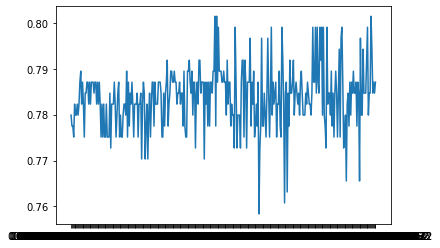

In [181]:
import matplotlib.pyplot as plt

print([key for key,value in history.items() if value > 0.8])
print([value for key,value in history.items() if value > 0.8])
plt.plot([key for key,value in history.items() if value > 0.7], [value for key,value in history.items() if value > 0.7])

### Instaciacion del modelo con el learning rate encontrado.

In [ ]:
keras.utils.set_random_seed(0)
model = build_model(0.09394269340974214)

### entrenamiento normal

In [13]:
history = model.fit(
    X_train,
    y_train,
    verbose=2, epochs=25,batch_size=32)

Epoch 1/25
28/28 - 1s - loss: 0.6887 - accuracy: 0.5758 - 1s/epoch - 41ms/step
Epoch 2/25
28/28 - 0s - loss: 0.5097 - accuracy: 0.7722 - 76ms/epoch - 3ms/step
Epoch 3/25
28/28 - 0s - loss: 0.4810 - accuracy: 0.7834 - 68ms/epoch - 2ms/step
Epoch 4/25
28/28 - 0s - loss: 0.4636 - accuracy: 0.7912 - 65ms/epoch - 2ms/step
Epoch 5/25
28/28 - 0s - loss: 0.4394 - accuracy: 0.8058 - 68ms/epoch - 2ms/step
Epoch 6/25
28/28 - 0s - loss: 0.4472 - accuracy: 0.8159 - 59ms/epoch - 2ms/step
Epoch 7/25
28/28 - 0s - loss: 0.4341 - accuracy: 0.8272 - 67ms/epoch - 2ms/step
Epoch 8/25
28/28 - 0s - loss: 0.4280 - accuracy: 0.8137 - 61ms/epoch - 2ms/step
Epoch 9/25
28/28 - 0s - loss: 0.4265 - accuracy: 0.8126 - 59ms/epoch - 2ms/step
Epoch 10/25
28/28 - 0s - loss: 0.4214 - accuracy: 0.8215 - 61ms/epoch - 2ms/step
Epoch 11/25
28/28 - 0s - loss: 0.4332 - accuracy: 0.8215 - 66ms/epoch - 2ms/step
Epoch 12/25
28/28 - 0s - loss: 0.4305 - accuracy: 0.8238 - 65ms/epoch - 2ms/step
Epoch 13/25
28/28 - 0s - loss: 0.4299 

 ## Evaluar con data 100% accuracy
 para evitar tener que estar subiendo constantemente la submission a kaggle, lo comparamos con el resultado final de la competición que se encuentra en un repo en github.

In [14]:
y_test = pd.read_csv('data/submission_100accuracy.csv')['Survived']

model.evaluate(test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 0.5080 - accuracy: 0.7871


[0.5079693794250488, 0.7870813608169556]

 ## Predicciones

In [188]:
preds = model.predict(test)
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0

14/14 [==============================] - 0s 2ms/step


 ## Exportar predicciones

In [189]:
prediction = pd.DataFrame({'PassengerId': test_data.PassengerId.values, 'Survived': preds.ravel().astype('int64')})
prediction.to_csv('data/results.csv', index=False)

In [190]:
prediction.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
